# Eluvio Challenge
## Kyeongho Min | longmini.seo@gmail.com

## 1. Loading the necessary libraries

In [1]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

## 2. Loading the dataset

In [2]:
df = pd.read_csv('Eluvio_DS_Challenge.csv')
df.head()

time_created date_created  up_votes  down_votes  \
0    1201232046   2008-01-25         3           0   
1    1201232075   2008-01-25         2           0   
2    1201232523   2008-01-25         3           0   
3    1201233290   2008-01-25         1           0   
4    1201274720   2008-01-25         4           0   

                                             title  over_18    author  \
0                Scores killed in Pakistan clashes    False     polar   
1                 Japan resumes refuelling mission    False     polar   
2                  US presses Egypt on Gaza border    False     polar   
3     Jump-start economy: Give health care to all     False   fadi420   
4  Council of Europe bashes EU&UN terror blacklist    False  mhermans   

    category  
0  worldnews  
1  worldnews  
2  worldnews  
3  worldnews  
4  worldnews

In [3]:
df.shape

(509236, 8)

## 3. Data analytics and preprocessing

### 3-1. Check for the null values

In [4]:
df.isnull().sum()

time_created    0
date_created    0
up_votes        0
down_votes      0
title           0
over_18         0
author          0
category        0
dtype: int64

There are no missing values in the dataset

### 3-2. Check the unique values for each column

In [7]:
columns = df.columns

print('total:', len(df))
for column in columns:
    print(column)
    print(len(df[column].unique()))
    print()

total: 509236
time_created
508329

date_created
3223

up_votes
5782

down_votes
1

title
500720

over_18
2

author
85838

category
1



##### Looks like there are unnecessary columns for this project, so I chose only two columns for NLP which are 'title' and 'over_18'. I would like to build up 'over_18' binary classification algorithm based on texts in 'title' column

### 3-3. Data cleaning

In [70]:
# Create new dataframe including two columns
df = df[['title', 'over_18']]

In [11]:
df.head()

title  over_18
0                Scores killed in Pakistan clashes    False
1                 Japan resumes refuelling mission    False
2                  US presses Egypt on Gaza border    False
3     Jump-start economy: Give health care to all     False
4  Council of Europe bashes EU&UN terror blacklist    False

In [71]:
# insert the new column containing the number of words in title column
df['title_len'] = df['title'].apply(lambda x: len(x.split(' ')))
df.head()

title  over_18  title_len
0                Scores killed in Pakistan clashes    False          5
1                 Japan resumes refuelling mission    False          4
2                  US presses Egypt on Gaza border    False          6
3     Jump-start economy: Give health care to all     False          8
4  Council of Europe bashes EU&UN terror blacklist    False          7

In [13]:
max(df['title_len'])

74

### 3-4. Check the class balance

In [14]:
balance_count = df.groupby('over_18')['over_18'].agg('count').values
balance_count

array([508916,    320])

In [19]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['False'],
    y=[balance_count[0]],
    name='False',
    text=[balance_count[0]],
    textposition='auto',
    marker_color = 'royalblue'
))
fig.add_trace(go.Bar(
    x=['True'],
    y=[balance_count[1]],
    name='True',
    text=[balance_count[1]],
    textposition='auto',
    marker_color = 'seagreen'
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

##### Looks the classes is extremely imbalanced, so I would like to consider some kind of resampling. I will try later.

### 3-5. Text cleaning

In [20]:
# cleaning the corpus
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [21]:
# insert new column - clean text 
df['title_clean'] = df['title'].apply(clean_text)
df.head()

title  over_18  title_len  \
0                Scores killed in Pakistan clashes    False          5   
1                 Japan resumes refuelling mission    False          4   
2                  US presses Egypt on Gaza border    False          6   
3     Jump-start economy: Give health care to all     False          8   
4  Council of Europe bashes EU&UN terror blacklist    False          7   

                                      title_clean  
0               scores killed in pakistan clashes  
1                japan resumes refuelling mission  
2                 us presses egypt on gaza border  
3      jumpstart economy give health care to all   
4  council of europe bashes euun terror blacklist

#### Stopwords
    Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. 

In [22]:
# remove stopwords

stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['title_clean'] = df['title_clean'].apply(remove_stopwords)
df.head()

title  over_18  title_len  \
0                Scores killed in Pakistan clashes    False          5   
1                 Japan resumes refuelling mission    False          4   
2                  US presses Egypt on Gaza border    False          6   
3     Jump-start economy: Give health care to all     False          8   
4  Council of Europe bashes EU&UN terror blacklist    False          7   

                                   title_clean  
0               scores killed pakistan clashes  
1             japan resumes refuelling mission  
2                 us presses egypt gaza border  
3          jumpstart economy give health care   
4  council europe bashes euun terror blacklist

#### Stemming 
    usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

In [23]:
# Stemming

stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['title_clean'] = df['title_clean'].apply(stemm_text)
df.head()

title  over_18  title_len  \
0                Scores killed in Pakistan clashes    False          5   
1                 Japan resumes refuelling mission    False          4   
2                  US presses Egypt on Gaza border    False          6   
3     Jump-start economy: Give health care to all     False          8   
4  Council of Europe bashes EU&UN terror blacklist    False          7   

                                title_clean  
0                 score kill pakistan clash  
1                japan resum refuel mission  
2                us press egypt gaza border  
3       jumpstart economi give health care   
4  council europ bash euun terror blacklist

#### Target encoding

In [25]:
# insert new encoded target column which are 0 or 1
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['over_18'])

df['target'] = le.transform(df['over_18'])
df.head()

title  over_18  title_len  \
0                Scores killed in Pakistan clashes    False          5   
1                 Japan resumes refuelling mission    False          4   
2                  US presses Egypt on Gaza border    False          6   
3     Jump-start economy: Give health care to all     False          8   
4  Council of Europe bashes EU&UN terror blacklist    False          7   

                                title_clean  target  
0                 score kill pakistan clash       0  
1                japan resum refuel mission       0  
2                us press egypt gaza border       0  
3       jumpstart economi give health care        0  
4  council europ bash euun terror blacklist       0

## 4. Tokens visualization

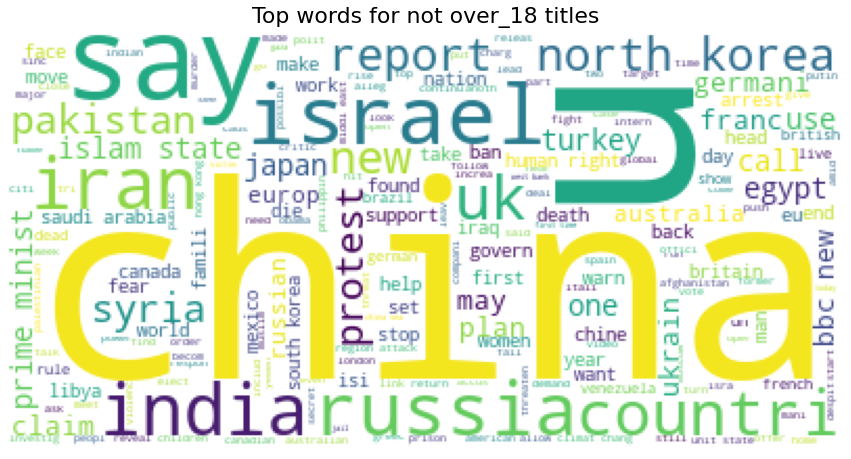

In [31]:
wc = WordCloud(background_color = 'white', 
    max_words = 200)

wc.generate(' '.join(text for text in df.loc[df['target'] == 0, 'title_clean']))
plt.figure(figsize=(15,8))
plt.title('Top words for not over_18 titles', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

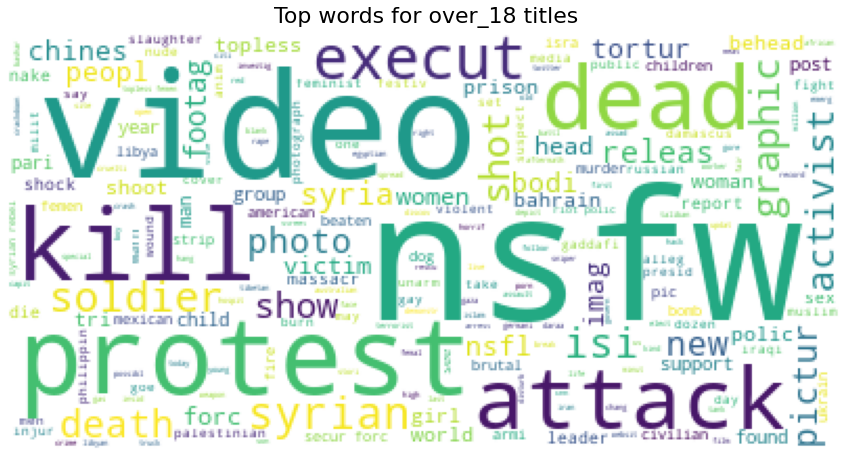

In [35]:
wc = WordCloud(background_color = 'white', 
    max_words = 200)

wc.generate(' '.join(text for text in df.loc[df['target'] == 1, 'title_clean']))
plt.figure(figsize=(15,8))
plt.title('Top words for over_18 titles', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)

plt.axis("off")
plt.show()

## 5. Vectorization

### 5-1. Tokenization

We need to perform tokenization - the processing of segmenting text into sentences of words. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing.

In [36]:
feature = df['title_clean']
target = df['target']

In [37]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(feature)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

92920

In [39]:
longest_train = max(feature, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

In [40]:
length_long_sentence

41

In [41]:
longest_train

"cousin say hungri sleep bush dead bodi nearbi stop “don't cry” say “that life” “no it life” say “or be” “it is” insist “that life like death last littl"

### 5-2. Pad_sequences

In [43]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

padded_texts = pad_sequences(embed(feature), padding = 'post', maxlen = length_long_sentence)

padded_texts

array([[1501,    3,   62, ...,    0,    0,    0],
       [  56, 1314, 7441, ...,    0,    0,    0],
       [   1,  565,   61, ...,    0,    0,    0],
       ...,
       [2237,  672,  290, ...,    0,    0,    0],
       [4433, 3991,    6, ...,    0,    0,    0],
       [  72, 5222, 2637, ...,    0,    0,    0]], dtype=int32)

In [44]:
len(padded_texts)

509236

In [45]:
target

0         0
1         0
2         0
3         0
4         0
         ..
509231    0
509232    0
509233    0
509234    0
509235    0
Name: target, Length: 509236, dtype: int64

### 5-3 Balancing

As I said before, the classes are extremely imbalanced, it is necessary to perform over-sampling using SMOTE (Synthetic Minority Over-sampling Technique).

In [47]:
import imblearn
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

In [48]:
X, y = oversample.fit_resample(padded_texts, target)

In [49]:
X

array([[1501,    3,   62, ...,    0,    0,    0],
       [  56, 1314, 7441, ...,    0,    0,    0],
       [   1,  565,   61, ...,    0,    0,    0],
       ...,
       [1375,  185,  475, ...,    0,    0,    0],
       [ 482,  526,  482, ...,    0,    0,    0],
       [  34,   73, 1383, ...,    0,    0,    0]], dtype=int32)

In [50]:
len(X)

1017832

In [51]:
y

0          0
1          0
2          0
3          0
4          0
          ..
1017827    1
1017828    1
1017829    1
1017830    1
1017831    1
Name: target, Length: 1017832, dtype: int64

In [77]:
print(sum(y == 0))
print(sum(y == 1))

508916
508916


##### Now, the dataset is balanced

### 5-4. GloVe

To obtain a vector representation for words we can use an unsupervised learning algorithm called GloVe (Global Vectors for Word Representation), which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.

Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. They have learned representations of text in an n-dimensional space where words that have the same meaning have a similar representation. Meaning that two similar words are represented by almost similar vectors that are very closely placed in a vector space.

Thus when using word embeddings, all individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network.

In [56]:
embeddings_dictionary = dict()
embedding_dim = 100

In [57]:
#load GloVe 100D embeddings
with open('glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [58]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33090001,  1.01110005,  1.54009998, ...,  0.030629  ,
         0.59236997,  0.41334   ],
       [-0.091682  ,  0.58104998,  0.40476999, ..., -0.38741001,
         0.34694999,  0.229     ],
       ...,
       [-1.07850003, -0.78926998,  0.25362   , ..., -0.77133   ,
        -0.014526  , -0.78184998],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [59]:
embedding_matrix.shape

(92920, 100)

## 6. Modeling

### LSTM

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [67]:
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1],
                       weights = [embedding_matrix], input_length = length_long_sentence))
    
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, 
                                           recurrent_dropout=0.2)))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 100)           9292000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 41, 82)            46576     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 82)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 82)                328       
_________________________________________________________________
dropout_3 (Dropout)          (None, 82)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 41)                3403      
_________________________________________________________________
dropout_4 (Dropout)          (None, 41)               

In [68]:
import tensorflow as tf

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, 
                                              restore_best_weights = True)

In [79]:
history = model.fit(X_train, y_train, epochs = 20, batch_size = 256, shuffle = True,
                    validation_split = 0.1, verbose = 1, callbacks = [early_stop])

Epoch 1/20
2684/2684 [==============================] - 615s 229ms/step - loss: 0.2353 - accuracy: 0.9074 - val_loss: 0.1631 - val_accuracy: 0.9343
Epoch 2/20
2684/2684 [==============================] - 568s 211ms/step - loss: 0.1637 - accuracy: 0.9391 - val_loss: 0.1376 - val_accuracy: 0.9456
Epoch 3/20
2684/2684 [==============================] - 572s 213ms/step - loss: 0.1313 - accuracy: 0.9528 - val_loss: 0.1246 - val_accuracy: 0.9535
Epoch 4/20
2684/2684 [==============================] - 570s 212ms/step - loss: 0.1111 - accuracy: 0.9607 - val_loss: 0.1148 - val_accuracy: 0.9561
Epoch 5/20
2684/2684 [==============================] - 587s 219ms/step - loss: 0.0972 - accuracy: 0.9663 - val_loss: 0.2207 - val_accuracy: 0.9262
Epoch 6/20
2684/2684 [==============================] - 706s 263ms/step - loss: 0.0859 - accuracy: 0.9705 - val_loss: 0.1062 - val_accuracy: 0.9599
Epoch 7/20
2684/2684 [==============================] - 629s 234ms/step - loss: 0.0777 - accuracy: 0.9737 - val_

#### The model stops its training by 12th epoch, which means the validation loss stop improving from 10th epoch.
#### We got around 96.06% of validation accuracy of our training dataset

## 7. Results

In [80]:
# Let's plot the results

def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

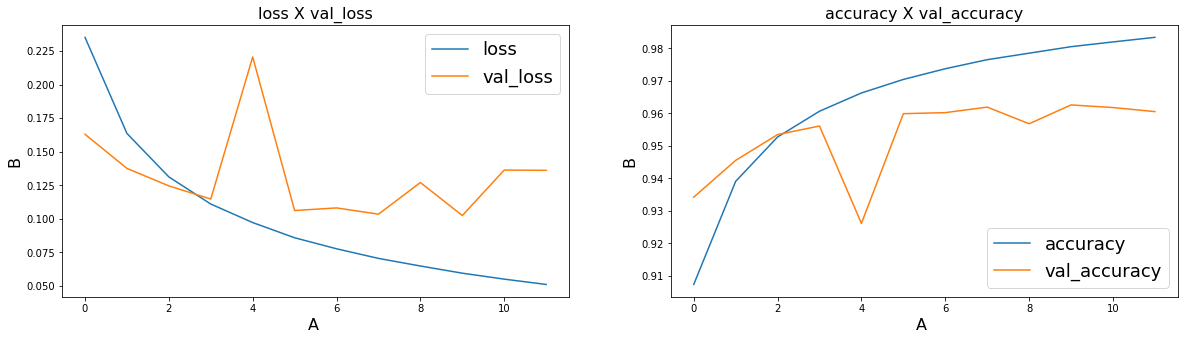

In [81]:
plot_learning_curves(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

In [82]:
train_score = model.evaluate(X_train, y_train)
test_score = model.evaluate(X_test, y_test)

7952/7952 [==============================] - 87s 11ms/step - loss: 0.1035 - accuracy: 0.9620


#### I got a training accuracy of 98.59% and testing of around 96.20%. As there is not much difference in the train and test accuracy, I can say that our model is not overfitting the data

### Let's extract the scores

In [83]:
# Confusion matrix

pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 
        

print('Accuracy on testing set: ', accuracy_score(binary_predictions, y_test))
print('Precision on testing set: ', precision_score(binary_predictions, y_test))
print('Recall on testing set: ', recall_score(binary_predictions, y_test))

Accuracy on testing set:  0.9620015876883415
Precision on testing set:  0.9617154729703242
Recall on testing set:  0.9624474295398908


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

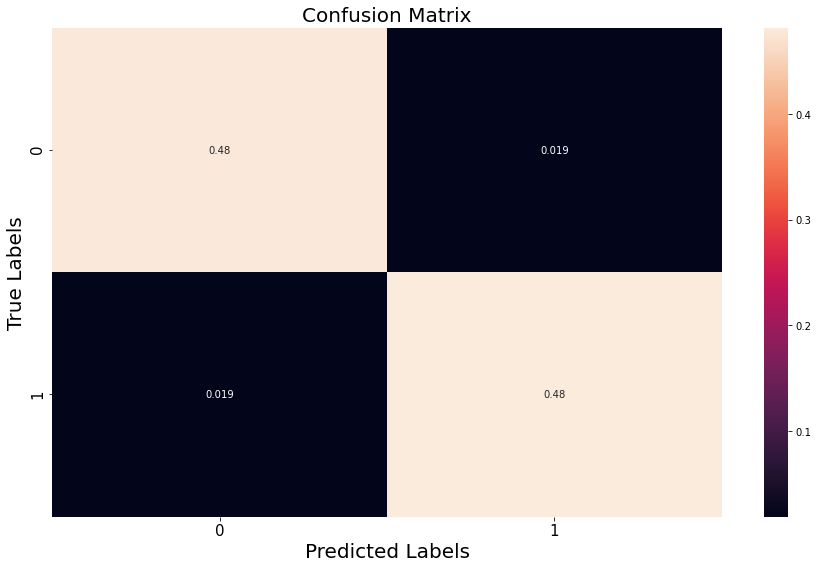

In [85]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions, y_test, normalize = 'all')
plt.figure(figsize=(15, 9))
ax = plt.subplot()
sns.heatmap(matrix, annot = True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size = 20)
ax.set_ylabel('True Labels', size = 20)
ax.set_title('Confusion Matrix', size = 20) 
ax.xaxis.set_ticklabels([0,1], size = 15)
ax.yaxis.set_ticklabels([0,1], size = 15)